In [1]:
import matplotlib.pyplot as plt

from model.modeling_llama import LlamaForCausalLM as ModifiedLlama
from transformers import AutoTokenizer, AutoModelForCausalLM
from kvcache.iterative import IterativeReduceKVBiasCache as ModifiedCache, IterativeReduceKVBiasCache
from transformers import DynamicCache
from datasets import load_dataset

import torch
import numpy as np
import random

import torch.nn.functional as F
import time
from IPython.display import DisplayHandle

import os
import random
import pandas as pd

import seaborn as sns

DEVICE = 'mps'
DTYPE = torch.float16
FIRST_N = 1000
SAMPLE_SIZE = 1
MAX_LENGTH = 700
PROTECT_FIRST = 20

In [2]:
# Define the cache file name
CACHE_FILENAME = f"fineweb_sample{SAMPLE_SIZE}of{FIRST_N}.csv"

# Check if the cache file already exists
if os.path.exists(CACHE_FILENAME):
    print(f"Cache file already exists: {CACHE_FILENAME}")
    df = pd.read_csv(CACHE_FILENAME)
else:
    # Load streaming dataset
    dataset = load_dataset("HuggingFaceFW/fineweb-edu", split="train", name="sample-10BT", streaming=True)
    stream = iter(dataset)

    # Take 1000 streamed samples
    samples = [next(stream) for _ in range(1000)]

    # Randomly select 10 of them
    selected_samples = random.sample(samples, SAMPLE_SIZE)

    # Convert to DataFrame
    df = pd.DataFrame(selected_samples)

    # Save to CSV
    df.to_csv(CACHE_FILENAME, index=False, encoding="utf-8")
    print(f"Saved CSV with {len(df)} samples to: {CACHE_FILENAME}")

texts = df["text"]

Cache file already exists: fineweb_sample1of1000.csv


In [3]:
def get_cache_size(cache: DynamicCache | ModifiedCache, max_len: int):
    n_layers = len(cache.key_cache)
    n_heads = len(cache.key_cache[0][0])
    
    if not isinstance(cache, ModifiedCache):
        for layer in range(n_layers):
            for head in range(n_heads):
                yield {'Layer ID': layer, 'Head ID': head, 'Cache Size (% of max)': 100}
    else:
        for layer, last_available_per_head in enumerate(cache.last_available_idx):
            last_available_per_head = last_available_per_head[0]
            for head, last_available in enumerate(last_available_per_head):
                # FIXME
                yield {'Layer ID': layer, 'Head ID': head, 'Cache Size (% of max)': 100 * (min(last_available.item() + 1, max_len) / max_len)}
                
                

def stepwise_perplexity(model, tokenizer, texts, cache_impl, update_every=10, max_length=MAX_LENGTH):
    loss_fn = torch.nn.CrossEntropyLoss()

    total_texts = len(texts)

    display_handle = DisplayHandle()
    display_handle.display("Starting perplexity evaluation...")
    
    # track: PPL, Text Idx, Step, Cache Class
    results = []
    
    # track: Cache Size (% of max), Layer ID, Head ID, Text Idx, Step
    results_cache = []

    for text_idx, text in enumerate(texts):
        enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        input_ids = enc["input_ids"].squeeze(0).to(model.device)
        cache = cache_impl()
        
        if isinstance(cache, ModifiedCache):
            cache_class = cache.__class__.__name__ + f"(MVI={cache.max_variance_increase:.1f}, PF={cache.protect_first})"
        else:
            cache_class = cache.__class__.__name__
        
        seq_len = input_ids.size(0)
        
        total_loss = 0.0
        total_tokens = 0

        # Autoregressive token-by-token loop
        for i in range(1, seq_len):
            input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]
            label_token = input_ids[i].unsqueeze(0)          # [1]

            with torch.no_grad():
                output = model(
                    input_ids=input_slice,
                    use_cache=True,
                    past_key_values=cache,
                    cache_position=torch.tensor([i - 1], device=DEVICE, dtype=torch.long),
                )
                cache = output.past_key_values
                logits = output.logits[:, -1, :]  # [1, vocab_size]
                loss = loss_fn(logits, label_token)
                total_loss += loss.item()
                total_tokens += 1

            # Update the display every update_every steps
            if total_tokens % update_every == 0 or (i == seq_len - 1 and text_idx == total_texts - 1):
                current_ppl = np.exp(total_loss / total_tokens)
                status = (f"Text {text_idx + 1}/{total_texts} | "
                          f"Token {i + 1}/{seq_len} | "
                          f"Global Steps: {total_tokens} | "
                          f"Cumulative PPL: {current_ppl:.2f}")
                display_handle.update(status)
            
            # Append current results:
            # For each token, we collect the current perplexity estimate, the cache class, 
            # the text index, and the current step number.
            results.append({
                "PPL": np.exp(total_loss / total_tokens),
                "Cache Class": cache_class,
                "Text Idx": text_idx,
                "Step": i
            })
            
            results_cache.extend([
                {
                    "Text Idx": text_idx,
                    "Step": i,
                    "Cache Class": cache_class,
                    **d
                }
                for d in get_cache_size(cache, max_len=i)  
            ])

    return results, results_cache

In [4]:
def plot(data):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="PPL", x="Step", data=pd.DataFrame(data), hue="Cache Class")
    plt.ylim((0, 40))
    
    
def plot_cache(data):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="Cache Size (% of max)", x="Step", data=pd.DataFrame(data), hue="Cache Class")

In [5]:
#texts = [texts[0]]

In [6]:
model_hf = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

'Text 1/1 | Token 693/693 | Global Steps: 692 | Cumulative PPL: 11.66'

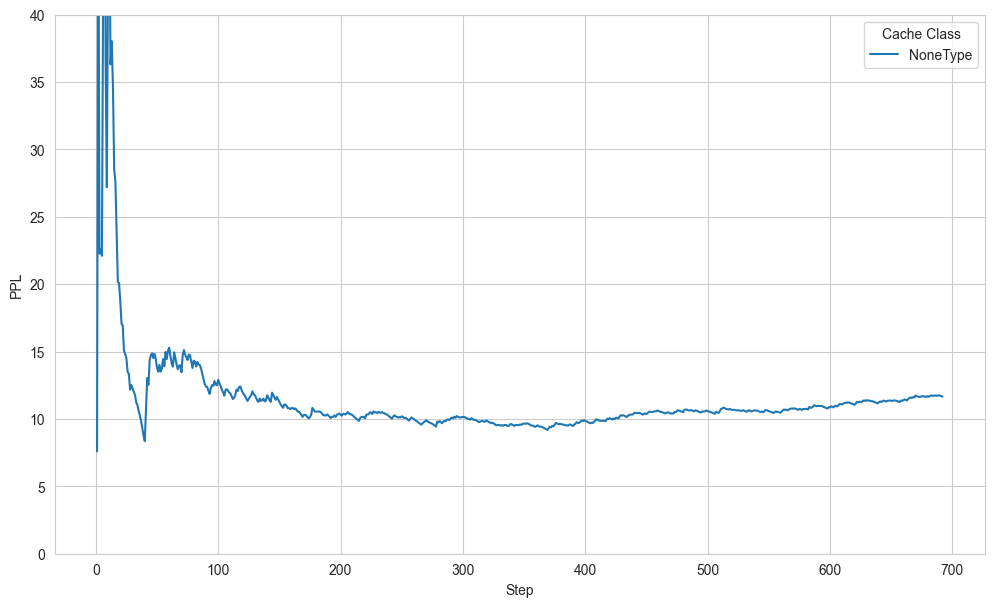

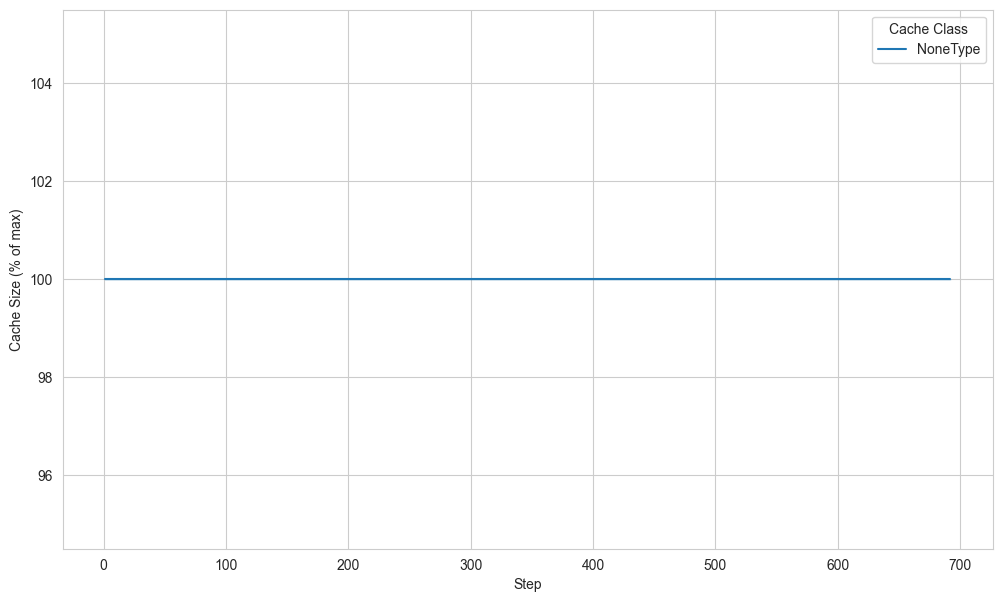

In [7]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
plot(results)
plot_cache(results_cache)

In [8]:
model_mod = ModifiedLlama.from_pretrained("HuggingFaceTB/SmolLM2-135M", attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

'Text 1/1 | Token 693/693 | Global Steps: 692 | Cumulative PPL: 15.01'

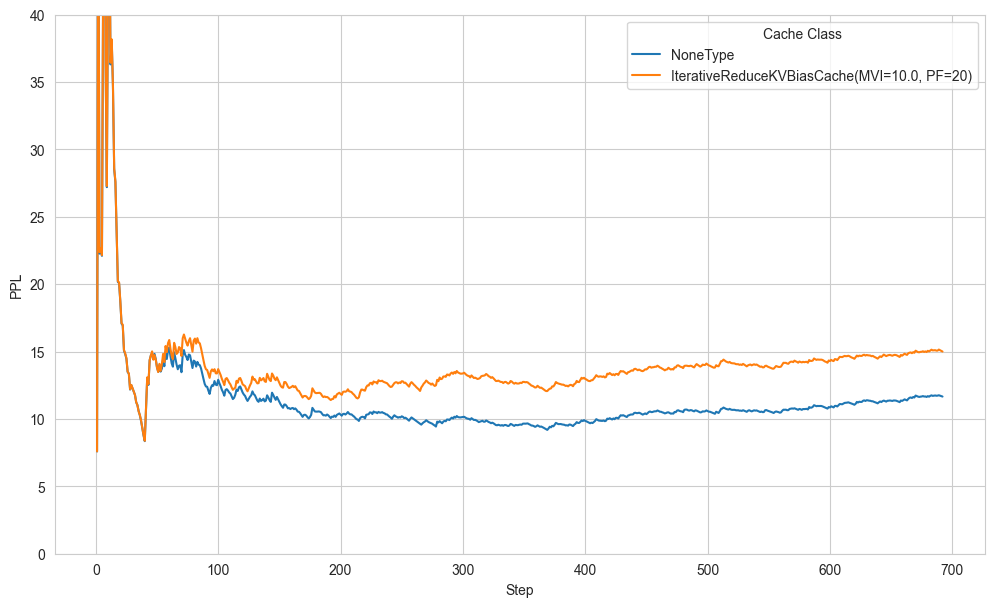

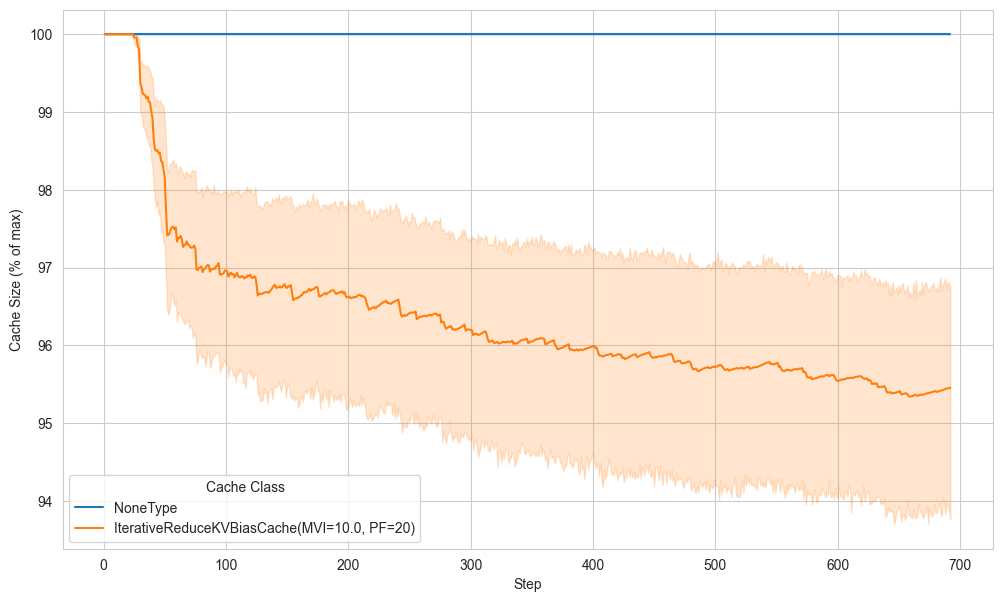

In [9]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=10.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

'Text 1/1 | Token 693/693 | Global Steps: 692 | Cumulative PPL: 12.79'

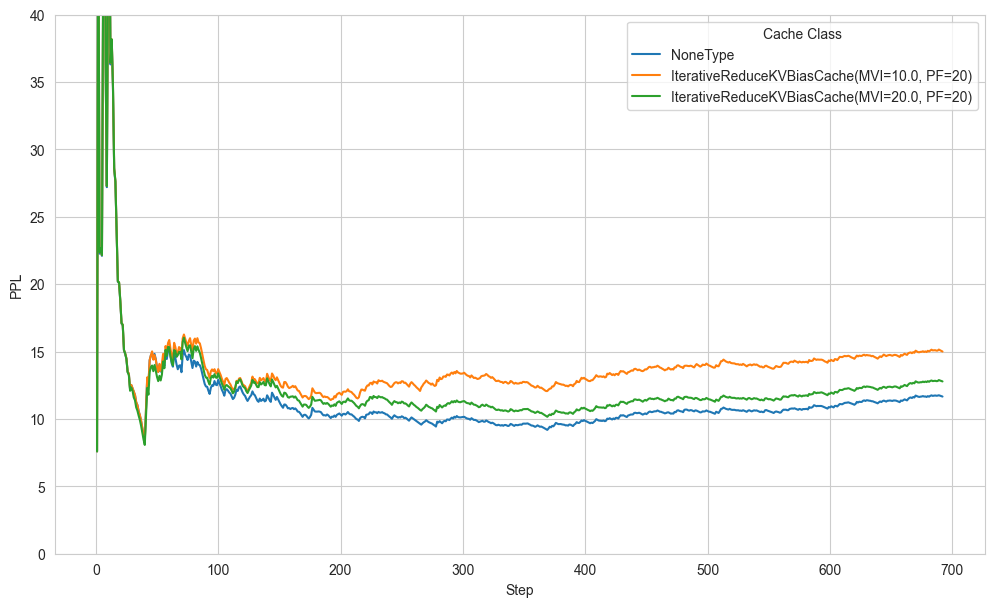

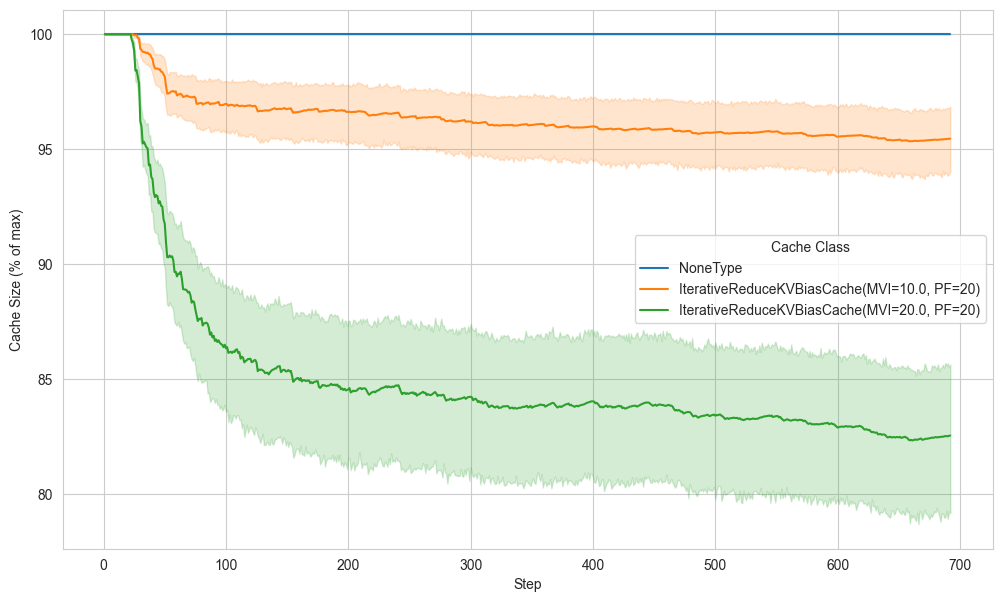

In [10]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=20.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

'Text 1/1 | Token 693/693 | Global Steps: 692 | Cumulative PPL: 12.93'

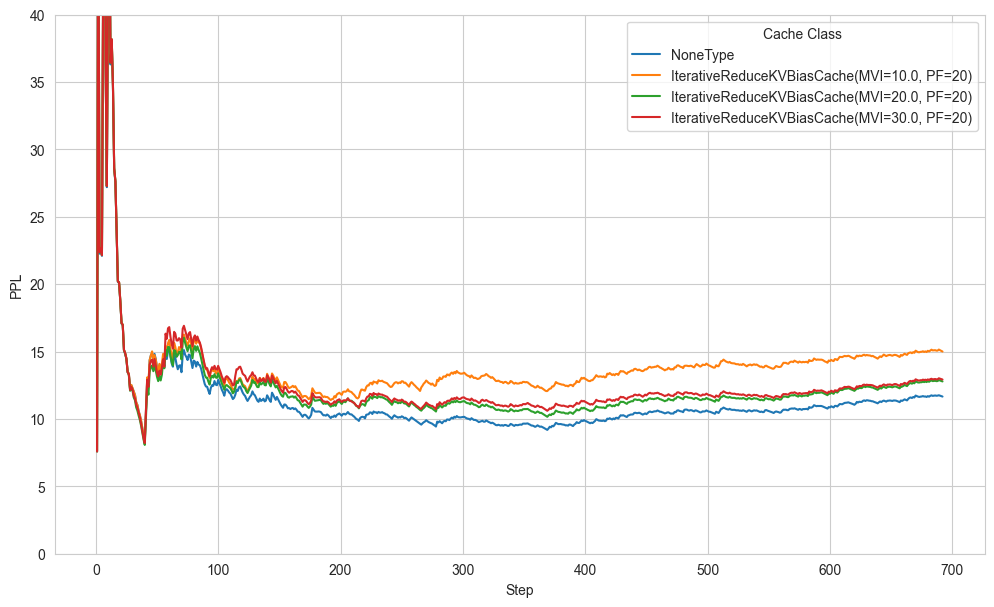

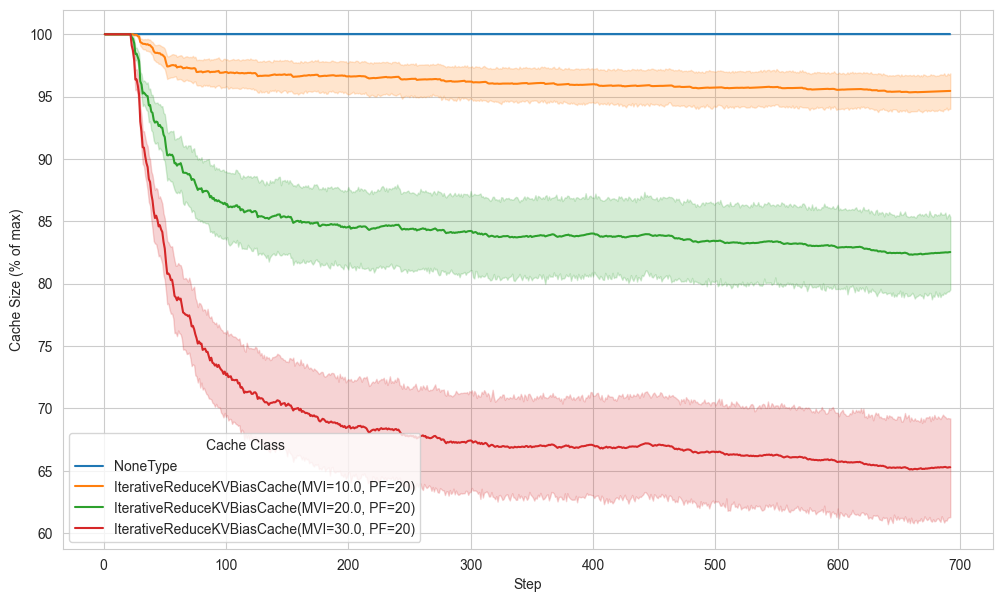

In [11]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=30.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

'Text 1/1 | Token 693/693 | Global Steps: 692 | Cumulative PPL: 16.39'

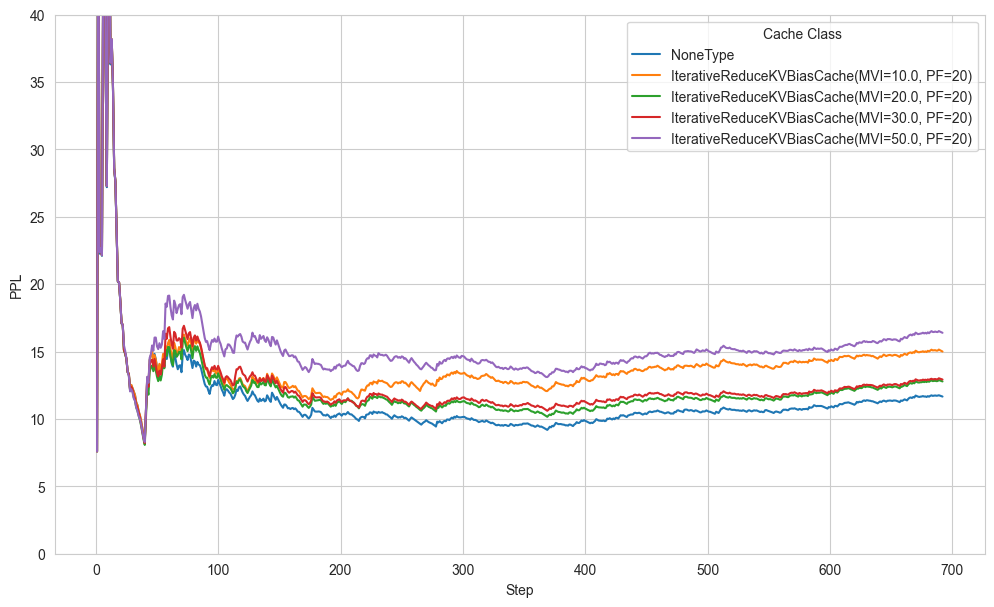

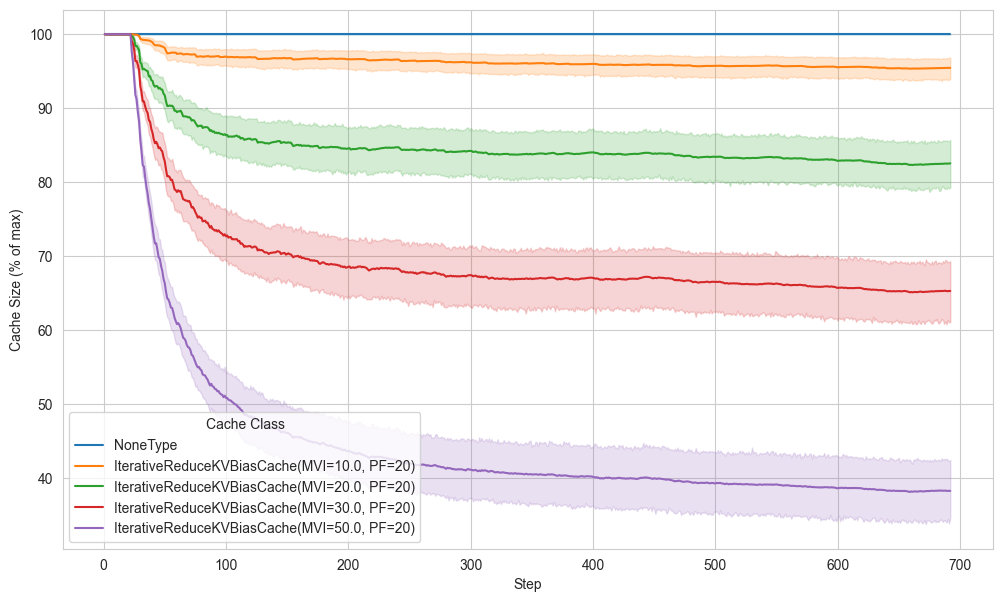

In [12]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=50.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

In [13]:
print(texts[0])

Self-Reliance in a Power Outage
People do not usually think of a power outage in the same light as an earthquake. However, when the power is out for a long period of time, citizen requests for fire, police, medical, and other public services will begin to mount. At some point, the increased demand for services could result in delayed response times.
For this reason, every citizen should learn to be self-reliant in an emergency. And even though power outages may only last a few hours, individuals and organizations should be prepared to be without assistance for 72 hours or longer.
To assist individuals prepare for an emergency, the City of San Mateo, State of California, American Red Cross, Federal Emergency Management Agency, and Pacific Gas and Electric Company have provided information on what to do during a power outage or other emergency.
- Check Circuit Breakers. If your power goes out, check your home's circuit breakers or fuses first. Your power could be out because a circuit ha

In [25]:
def stepwise_generate(model, tokenizer, prompt, cache_impl, update_every=10, n_generate=100):
    display_handle = DisplayHandle()
    display_handle.display("Starting generation...")

    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].squeeze(0).to(model.device)
    cache = cache_impl()
    
    seq_len = input_ids.size(0)

    # Autoregressive token-by-token loop
    for i in range(1, seq_len + n_generate):
        input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]

        with torch.no_grad():
            output = model(
                input_ids=input_slice,
                use_cache=True,
                past_key_values=cache,
                cache_position=torch.tensor([i - 1], device=DEVICE, dtype=torch.long),
            )
            logits = output.logits[0, -1, :]  # [vocab_size]
            predicted_token = logits.argmax(dim=-1)
            
            if i >= len(input_ids):
                input_ids = torch.cat((input_ids, predicted_token.unsqueeze(0)), dim=-1)

        # Update the display every update_every steps
        status = tokenizer.decode(input_ids)
        display_handle.update(status)

In [26]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=50.0, protect_first=PROTECT_FIRST))

'Once upon a time, 100 years ago, there was a man named John D. Rockefeller. He owned a big company called Standard Oil. He owned a big company called Standard Oil. Standard was a big company that made many things like cars, trucks, and even toys!\n\nOne day, John D. D. decided to take a trip to a place called the "Big Apple.\n'

KeyboardInterrupt: 

In [29]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=0.0, protect_first=PROTECT_FIRST))

'Once upon a time, 100 years ago, there was a man named John D. Rockefeller. He was a businessman who owned many businesses around the world. One day, he decided to start a company called Standard Oil. Standard Oil was a big company that made oil and other products.\n\nStandard Oil was very important because it helped people get oil and other products. But, it also had some problems. For example, Standard Oil made a'

KeyboardInterrupt: 

In [30]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=20.0, protect_first=PROTECT_FIRST))

"Once upon a time, 100 years ago, there was a man named John D. Rockefeller. He was a businessman who owned many businesses around the world, including the oil industry. But what made him so special? Let's find out!\n\nImagine you have a lemonade stand. You sell lemonade to kids in their neighborhood. One day, someone tells him that he can become even more successful by starting his own business. That's what happened to John D. Rockefeller!\n"

KeyboardInterrupt: 